<a href="https://colab.research.google.com/github/azz2k/vendor_challenge/blob/main/vendor_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic assumtions and simplifications
* To make my life easier I will remove everything but [a-zA-Z] and whitespaces, which is very restrictive
* For now I will ignore the order of words in text and description as I have limited time
* I'm not going to attempt to use a Transformer for this task as it would take too much time and ressources

# libraries, constants, etc.

In [1]:
from google.colab import drive

import pandas as pd
import numpy as np

import sklearn.model_selection
import sklearn.decomposition
import sklearn.manifold

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

import nltk
import gensim

This should later be put into: requirements installations (in separate requirements file)

In [2]:
# Punkt sentence tokenizer
nltk.download("punkt")
# Word List Corpus
nltk.download("words")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

# read data


In [3]:
# mount google drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# read parquet file
products_all_raw_df = pd.read_parquet("/content/drive/MyDrive/Data Science/products.parquet.gz")
products_all_raw_df

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count
0,0,0,w21z6tu,Cheese Tofu,None,116
1,1,1,w21z74d,Naughty & Nice - Slice,Chocolate - Slice,30
2,2,2,w21xxgu,301. Pork Dumpling with Hot Chilli Vinaigrette...,"6 Pcs, spicy",25
3,3,3,w23b4u1,Mee Kuah,Contain minced mutton meat,45
4,4,4,w21ztq4,Ham & Cheese Sandwich Set,"Toasted to perfection, this sandwich hits all ...",24
...,...,...,...,...,...,...
633143,633143,701,w21zkpm,Sriracha Chicken Whole Wheat Pita,None,22
633144,633144,17,w23b5j9,Dettol Liquid Hand wash Sensitive 250ml,â€¢ Dettol Liquid Hand Wash kills 99.9% of ger...,22
633145,633145,4135,w21ztw0,Red Bean,4 Pcs,22
633146,633146,3121,w21z6vc,Twister Meal,"Choice of 1 Twister, 1 Hash Brown and choice o...",22


# look at target

In [5]:
products_all_raw_df["order_count"].describe()

count    633148.000000
mean          9.482963
std          24.025783
min           1.000000
25%           1.000000
50%           3.000000
75%           8.000000
max        1386.000000
Name: order_count, dtype: float64

In [6]:
products_all_raw_df.nlargest(20, "order_count")

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count
3845,3845,903,w21zs0h,2pc Chickenjoy VM,"2pc Chickenjoy, 1 Side, 1 Drink, 1 Gravy",1386
18078,18078,19,w23b4j4,Chew's Fresh Brown Eggs with Vitamin E 10s x 60g,,1358
21402,21402,19,w23b4j4,Chew's Corn and Soya Fresh Brown Eggs with Vit...,,1277
45838,45838,1421,w21zwre,Chicken Coney Dog with Beef Sauce Combo,"1 Chicken Coney Dog with Beef Sauce, 1 Reg Cur...",1206
3739,3739,36,w21zey6,Anchor Strong Pilsner Beer Can 490ml,With its long standing European heritage and b...,1196
36414,36414,106,w21z6cf,Fresh Banana 5s,Country of Origin: Philippines,1037
22908,22908,1760,w21zg1k,2 pcs Golden Aroma® Chicken Combo,"2 pieces Golden Aroma® Chicken,1 Reg Curly Fri...",996
51321,51321,1421,w21zwre,Mozza Burger® Combo,"1 Mozza Burger® , 1 Reg Curly Fries & 1 Reg A&...",978
44013,44013,1421,w21zwre,2 pcs Golden Aroma® Chicken Combo,"2 pieces Golden Aroma® Chicken,1 Reg Curly Fri...",961
2976,2976,1421,w21zwre,Double Cheeseburger Combo,"1 Double Cheeseburger, 1 Reg Curly Fries & 1 R...",955


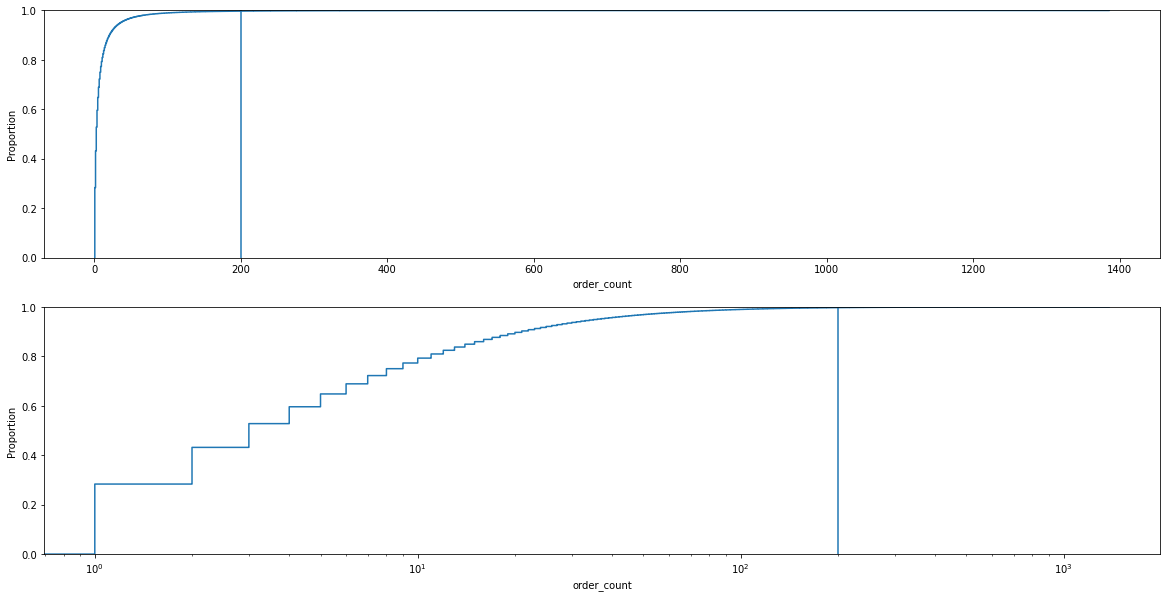

In [7]:
# plot the order count ecdf
fig, ax = plt.subplots(2, 1, figsize = (20, 10))
sns.ecdfplot(
    data=products_all_raw_df,
    x="order_count",
    ax=ax[0]
)
ax[0].axvline(200)
sns.ecdfplot(
    data=products_all_raw_df,
    x="order_count",
    ax=ax[1]
)
ax[1].set_xscale("log")
ax[1].axvline(200)
plt.show()

That is a target distribution we don't really want to see. Most orders are less than five and only a few orders have a significant number. We need to sample from more than just one month to make useful predictions.

We need to apply some transform to order_count, probably log and then clip at 200 or something like that.

# data cleanup

## train test split

In [8]:
# sample data for testing
products_sample_raw_df = products_all_raw_df.copy() #sample(20000)

In [9]:
# train test split
products_sample_raw_train_df, products_sample_raw_test_df = sklearn.model_selection.train_test_split(products_sample_raw_df, test_size=0.2)

## data normalization

In [10]:
# use these keys to normalize
primary_keys = ["product_id", "vendor_id", "vendor_geohash"]

In [11]:
# split into a more normalized form
products_raw_df = products_sample_raw_train_df[primary_keys + ["order_count"]].copy()
products_name_raw_df = products_sample_raw_train_df[primary_keys + ["product_name"]].copy().rename({"product_name": "text"}, axis=1)
products_description_raw_df = products_sample_raw_train_df[primary_keys + ["product_description"]].copy().rename({"product_description": "text"}, axis=1)

## basic cleanup

In [12]:
products_df = products_raw_df.copy()
products_name_df = products_name_raw_df.copy()
products_description_df = products_description_raw_df.copy()

In [13]:
# drop empty text
products_name_df.dropna(inplace=True)
products_description_df.dropna(inplace=True)

# replace everything but basic chars for now
products_name_df["text"].replace("[^a-zA-Z ]", " ", inplace=True, regex=True)
products_description_df["text"].replace("[^a-zA-Z ]", " ", inplace=True, regex=True)

# remove single and double characters
products_name_df["text"].replace("(^| ).( |$)", " ", inplace=True, regex=True)
products_name_df["text"].replace("(^| )..( |$)", " ", inplace=True, regex=True)
products_description_df["text"].replace("(^| ).( |$)", " ", inplace=True, regex=True)
products_description_df["text"].replace("(^| )..( |$)", " ", inplace=True, regex=True)

# remove all double whitespaces
products_name_df["text"].replace("[ ]+", " ", inplace=True, regex=True)
products_description_df["text"].replace("[ ]+", " ", inplace=True, regex=True)

# drop empty text
products_name_df["text"].replace("^[ ]+$", "", inplace=True, regex=True)
products_name_df = products_name_df[products_name_df["text"] != ""]

products_description_df["text"].replace("^[ ]+$", "", inplace=True, regex=True)
products_description_df = products_description_df[products_description_df["text"] != ""]

In [14]:
# to lower
products_name_df["text"] = products_name_df["text"].str.lower()
products_description_df["text"] = products_description_df["text"].str.lower()

In [15]:
products_name_df

,product_id,vendor_id,vendor_geohash,text
410166,410166,9723,w21z3b6,white
571159,571159,195,w21zu1v,chicken mcnuggets
599047,599047,1911,w21zkqp,delifrance chicken mayo sandwich s
593733,593733,4357,w21ze4k,curry chicken rice
295015,295015,4207,w21z6ug,cheesy zinger buddy meal
...,...,...,...,...
448496,448496,5345,w21z3jm,fried hokkien noodle deal for pax
608501,608501,3363,w21z6wn,mozzarella sticks
147153,147153,6730,w21zuhd,maggi hot heads spicy curry cup noodles
293313,293313,183,w21zg1c,apple pie


In [16]:
products_description_df

,product_id,vendor_id,vendor_geohash,text
410166,410166,9723,w21z3b6,espresso hot milk
571159,571159,195,w21zu1v,great for sharing with friends
295015,295015,4207,w21z6ug,cheesy zinger pcs chicken includes drumstick ...
284569,284569,4976,w21zthv,recommended topping available
428710,428710,4179,w21zscp,pcs
...,...,...,...,...
393381,393381,383,w21zerf,glutinous rice flour gluten free makes for exc...
16383,16383,3947,w21z7hc,pcs chicken pcs nuggets side and drink
448496,448496,5345,w21z3jm,comes with fried hokkien noodle beverages
608501,608501,3363,w21z6wn,pcs


## tokenization and stemming

In [17]:
products_name_token_df = products_name_df.copy()
products_description_token_df = products_description_df.copy()

In [18]:
# tokenization
products_name_token_df["text_tokens"] = products_name_token_df["text"].transform(nltk.word_tokenize)
products_description_token_df["text_tokens"] = products_description_token_df["text"].apply(nltk.word_tokenize)

In [19]:
# add a position index and explode
products_name_token_df["idx"] = 1
products_name_token_df = products_name_token_df.explode("text_tokens")
products_name_token_df["idx"] = products_name_token_df.groupby(primary_keys)["idx"].cumsum()

products_description_token_df["idx"] = 1
products_description_token_df = products_description_token_df.explode("text_tokens")
products_description_token_df["idx"] = products_description_token_df.groupby(primary_keys)["idx"].cumsum()

In [20]:
# stemming which we will need later for word2vec
snowball = nltk.stem.SnowballStemmer(language="english")
products_name_token_df["text_tokens_stemmed"] = products_name_token_df["text_tokens"].apply(lambda x: snowball.stem(x))
products_description_token_df["text_tokens_stemmed"] = products_description_token_df["text_tokens"].apply(lambda x: snowball.stem(x))

## filter english items

The general idea here is to count the fraction of english words in name and description and to use this in some way to filter english items.

### checking if tokens are english and couting etc.

In [21]:
# check if text_tokens are in words corpus
words = nltk.corpus.words.words()
products_name_token_df["is_english"] = products_name_token_df["text_tokens"].isin(words)
products_description_token_df["is_english"] = products_description_token_df["text_tokens"].isin(words)

In [22]:
products_english_df = products_df.copy()

# count english words and total words for product name
products_english_df = products_english_df.merge(
    products_name_token_df.groupby(primary_keys)["is_english"].sum().reset_index().rename({"is_english": "name_is_english"}, axis=1), 
    on=primary_keys, 
    how="left")
products_english_df = products_english_df.merge(
    products_name_token_df.groupby(primary_keys)["is_english"].size().reset_index().rename({"is_english": "name_n_words"}, axis=1), 
    on=primary_keys, 
    how="left")

# count english words and total words for product description
products_english_df = products_english_df.merge(
    products_description_token_df.groupby(primary_keys)["is_english"].sum().reset_index().rename({"is_english": "description_is_english"}, axis=1), 
    on=primary_keys, 
    how="left")
products_english_df = products_english_df.merge(
    products_description_token_df.groupby(primary_keys)["is_english"].size().reset_index().rename({"is_english": "description_n_words"}, axis=1), 
    on=primary_keys, 
    how="left")

# replace nans etc. from empty text and cast back to int
for col in ["name_is_english", "name_n_words", "description_is_english", "description_n_words"]:
    products_english_df[col] = products_english_df[col].replace(np.nan, 0).astype(int)

In [23]:
# calculate the actual frequency = score
products_english_df["total_is_english"] = products_english_df["name_is_english"] + products_english_df["description_is_english"]
products_english_df["total_n_words"] = products_english_df["name_n_words"] + products_english_df["description_n_words"]
products_english_df["english_score"] = products_english_df["total_is_english"] / products_english_df["total_n_words"]

In [24]:
# drop ones with no english score
products_english_df = products_english_df[~products_english_df["english_score"].isna()]

### filter metric exploration

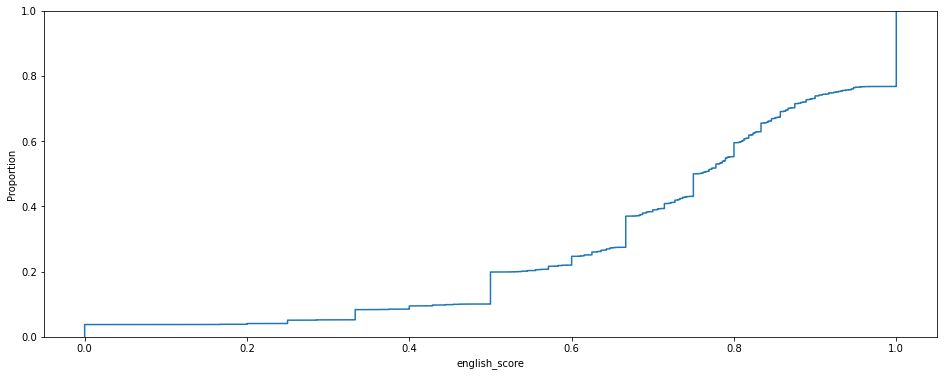

In [25]:
# plot the english score ecdf
fig, ax = plt.subplots(1, 1, figsize=(16,6))
sns.ecdfplot(
    data=products_english_df,
    x="english_score",
    ax=ax
)
plt.show()

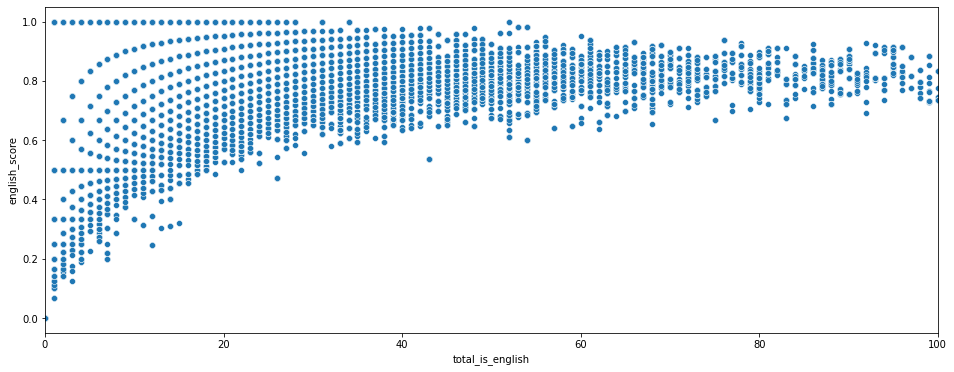

In [26]:
# plot the english score as a function of english words
fig, ax = plt.subplots(1, 1, figsize=(16,6))
sns.scatterplot(
    data=products_english_df,
    x="total_is_english",
    y="english_score",
    ax=ax
)
ax.set_xlim(0, 100)
plt.show()

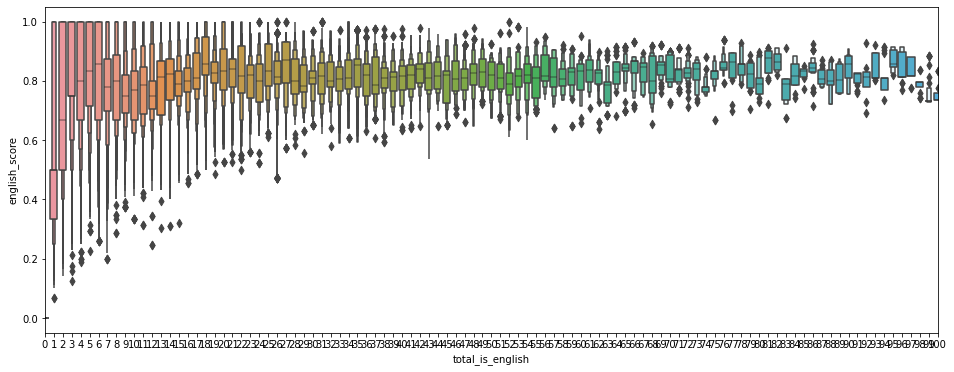

In [27]:
# plot the english score as a function of english words
fig, ax = plt.subplots(1, 1, figsize=(16,6))
sns.boxenplot(
    data=products_english_df,
    x="total_is_english",
    y="english_score",
    ax=ax
)
ax.set_xlim(0, 100)
plt.show()

In [28]:
products_sample_raw_train_df.merge(products_english_df[(products_english_df["english_score"] > 0.2) & (products_english_df["english_score"] < 0.3)][primary_keys], on=primary_keys, how="inner")

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count
0,537227,5554,w21zetv,Hazelnut Mee Chiang Kueh,None,9
1,249620,4258,w21zt11,48. Kimchi Beancurd Udon,Spicy,2
2,427176,5087,w23b4w7,A13. Homemade Tamago Mentai,4 Pcs,4
3,446949,4439,w23bh23,CP Roasted Hot Wings (drumlet) | 1 kg,None,5
4,188701,6082,w21z71v,Shizuoka Matcha Avocado Smoothie 静岡の抹茶牛油果冰沙,None,1
...,...,...,...,...,...,...
5683,83487,10063,w21xxvd,Fried Lala Hokkien Mee,None,1
5684,630686,243,w21zt4t,Epok Epok Potato,3 Pcs,22
5685,331847,1381,w23b1uk,LACTASOY UHT SOYMILK HI-CAL (5077574) | 500 ml,None,3
5686,390781,17,w23b5j9,Wei's Summer Berries Sorbet 1L,,3


In [29]:
products_sample_raw_train_df.merge(products_english_df[(products_english_df["english_score"] > 0.6) & (products_english_df["english_score"] < 0.7)][primary_keys], on=primary_keys, how="inner")

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count
0,295015,4207,w21z6ug,Cheesy Zinger Buddy Meal,"1 Cheesy Zinger, 3 pcs Chicken (includes 1 dru...",2
1,65820,7598,w21zkmn,(01-25) Braised Duck Porridge,None,1
2,377989,688,w21ztw0,TH01. Bean Curd Hotplate,None,3
3,545323,1786,w21zkmn,Cheese Egg Prata,None,9
4,410856,682,w21z6ek,Ham & Cheese Croissant,None,4
...,...,...,...,...,...,...
69440,292279,9246,w21z71c,Mini Raspberry Yogurt Lychee Log Cake,A delightful & refreshing mini log cake,2
69441,168298,3703,w21zux7,Iced Hojicha Tea Latte,Carefully roasted over charcocal to evoke a wa...,1
69442,99227,5503,w21z6tr,Taro Milk Tea,Recommended. Toppings available,1
69443,503336,8777,w21zg1k,6 Pcs Spicy Drumlets,Mild spicy drumlets which best match with our ...,7


In [30]:
products_sample_raw_train_df.merge(products_english_df[products_english_df["total_is_english"] == 0 ][primary_keys], on=primary_keys, how="inner")

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count
0,357047,7579,w21z8yp,Mee Goreng Combo,None,3
1,446751,3357,w23b4uz,Mee Goreng,None,5
2,613397,6098,w21ze4y,Goreng Thai,None,17
3,95806,3105,w23bh25,S8. Lemongrass Sugarcane,None,1
4,569889,5376,w21zt1b,Yi Mee伊面,None,11
...,...,...,...,...,...,...
19152,9210,1011,w21zts2,Mee Goreng,None,26
19153,602603,4779,w21zejk,Chapati,1 Pc,16
19154,603383,1479,w21zupz,07. Laksa Mini Wok Noodles,None,16
19155,627719,778,w21ztw0,MW22. Carbonara Pasta,None,21


In [31]:
products_sample_raw_train_df.merge(products_english_df[products_english_df["total_is_english"] == 1][primary_keys], on=primary_keys, how="inner")

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count
0,88742,4915,w21z7pb,Sprite,None,1
1,254847,335,w21zejn,SCHWEPPES TONIC 4S (5026054) | 4x320 ml,None,2
2,318693,7689,w23b60u,Y9. Avocado Milkshake,None,2
3,3553,62,w21z7k1,Coffee 咖啡,None,43
4,233378,9753,w21z8dx,12. 水饺 Steamed Dumpling,None,1
...,...,...,...,...,...,...
57333,600107,3529,w21zexn,129. Chicken 65,None,15
57334,135337,7752,w21zt12,Strawberry Smoothie,None,1
57335,399664,5878,w21ze9g,NABISCO RITZ CRACKERS (5000308) | 300 g,None,4
57336,193542,6578,w21ztq0,Dalgona Coffee 160z,None,1


In [32]:
products_sample_raw_train_df.merge(products_english_df[products_english_df["total_is_english"] == 2][primary_keys], on=primary_keys, how="inner")

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count
0,65820,7598,w21zkmn,(01-25) Braised Duck Porridge,None,1
1,377989,688,w21ztw0,TH01. Bean Curd Hotplate,None,3
2,105599,1270,w21z373,T16. Hot & Spicy,None,1
3,428710,4179,w21zscp,Salmon Sushi &Teriyaki Chicken,6pcs,4
4,545323,1786,w21zkmn,Cheese Egg Prata,None,9
...,...,...,...,...,...,...
80273,594026,3107,w21zguh,13. Chicken Porridge,None,14
80274,10909,704,w23b1sf,Onion Rings (Large),None,27
80275,44009,1552,w21zu00,Fragrance Eggplant 酱香茄子,None,40
80276,130505,958,w23b4u5,Coke Zero,None,1


In [33]:
products_sample_raw_train_df.merge(products_english_df[products_english_df["total_is_english"] == 3][primary_keys], on=primary_keys, how="inner")

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count
0,410166,9723,w21z3b6,White,Espresso + hot milk,4
1,599047,1911,w21zkqp,13128772 Delifrance Chicken Mayo Sandwich 1's,None,15
2,593733,4357,w21ze4k,Curry Chicken Rice,None,14
3,578031,17,w23b5j9,Lotte Ghana Milk Chocolate 70g,,12
4,74659,3771,w21zu1s,13096464 Jack & Jill Potato Chips - BBQ (70g),None,1
...,...,...,...,...,...,...
70480,425192,298,w21zs53,Da Hong Pao Milk Tea + 3 Ho,None,4
70481,396539,2450,w21z7jv,Chicken Chop (Indian Style),None,4
70482,50137,712,w23b4rz,Handmade Ban Mian 手工板面,None,169
70483,24410,35,w21zs05,3003. Century Egg Porridge,None,50


Looks like the english score is not yet good enough. I'll stick for now to "at least one english word", which is also the easiest option. This can always be improved at a later stage.

### actual filtering

In [34]:
products_english_filtered_df = products_english_df.copy()
products_english_filtered_df = products_english_filtered_df[products_english_filtered_df["total_is_english"] > 0]

In [35]:
len(products_df), len(products_english_filtered_df)

(506518, 487223)

# cleanup verdict
Obviously we could improve our cleanup and subsequent filtering by a lot.

* better character level cleaning
* better dictionary (also include more culinary terms like croissant, alfredo, pepsi, some basic chinese dishes, etc.)
* english filtering is now only done by number of english words, but other metrics could be better (like and improved version of the english score I tried)

For now it seems to be good enough.

# word2vec embedding

In [36]:
doc_keys = primary_keys + ["order_count"]

## gather data

In [37]:
products_name_doc_df = (products_english_filtered_df[doc_keys]
 .merge(products_name_token_df, on=primary_keys, how="inner")
 .groupby(doc_keys)["text_tokens_stemmed"]
 .agg(list)
 .reset_index()
 .rename({"text_tokens_stemmed": "name_tokens"}, axis=1))

In [38]:
products_description_doc_df = (products_english_filtered_df[doc_keys]
 .merge(products_description_token_df, on=primary_keys, how="inner")
 .groupby(doc_keys)["text_tokens_stemmed"]
 .agg(list)
 .reset_index()
 .rename({"text_tokens_stemmed": "description_tokens"}, axis=1))

In [39]:
products_doc_df = products_name_doc_df.merge(products_description_doc_df, on=doc_keys, how="left")
products_doc_df

,product_id,vendor_id,vendor_geohash,order_count,name_tokens,description_tokens
0,0,0,w21z6tu,116,"[chees, tofu]",NaN
1,1,1,w21z74d,30,"[naughti, nice, slice]","[chocol, slice]"
2,2,2,w21xxgu,25,"[pork, dumpl, with, hot, chilli, vinaigrett]","[pcs, spici]"
3,5,5,w21z6dm,39,"[chicken, dum, biryani, set]",NaN
4,6,6,w21zts2,28,"[sesam, chicken, with, rice]",NaN
...,...,...,...,...,...,...
487197,633143,701,w21zkpm,22,"[sriracha, chicken, whole, wheat, pita]",NaN
487198,633144,17,w23b5j9,22,"[dettol, liquid, hand, wash, sensit]","[dettol, liquid, hand, wash, kill, germ, ensur..."
487199,633145,4135,w21ztw0,22,"[red, bean]",[pcs]
487200,633146,3121,w21z6vc,22,"[twister, meal]","[choic, twister, hash, brown, and, choic, drink]"


## train embedding

I will ignore hyperparameter tuning of Word2Vec for now.

In [40]:
w2v_names = gensim.models.Word2Vec(products_doc_df["name_tokens"])
w2v_descriptions = gensim.models.Word2Vec(products_doc_df["description_tokens"].dropna())

## inspect embedding

In [41]:
# look at name embedding
def plot_w2v_model(model):
  vectors = np.asarray(model.wv.vectors)
  labels = np.asarray(model.wv.index2entity)

  tsne = sklearn.manifold.TSNE(n_components=2)
  vectors = tsne.fit_transform(vectors)

  vectors_df = pd.DataFrame(vectors, columns=["x", "y"])
  vectors_df["label"] = labels

  fig, ax = plt.subplots(1, 1, figsize=(20, 20))
  sns.scatterplot(
      data=vectors_df,
      x="x",
      y="y",
      ax=ax
  )
  for index, row in vectors_df.sample(100).iterrows():
    plt.annotate(
        s=row["label"],
        xy=(row["x"], row["y"])
    )
  plt.show()

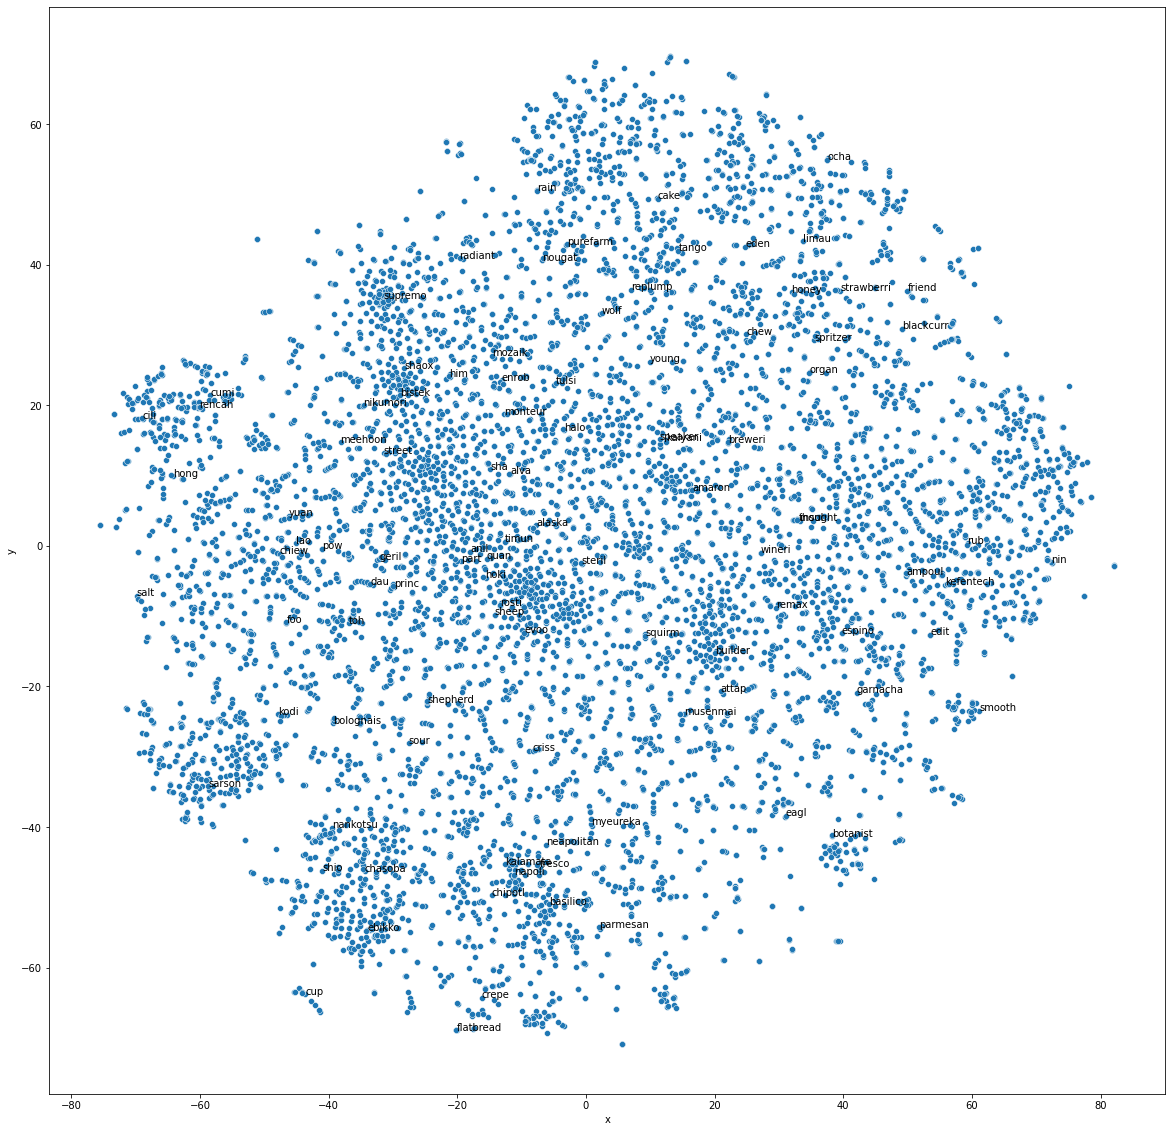

In [42]:
plot_w2v_model(w2v_names)

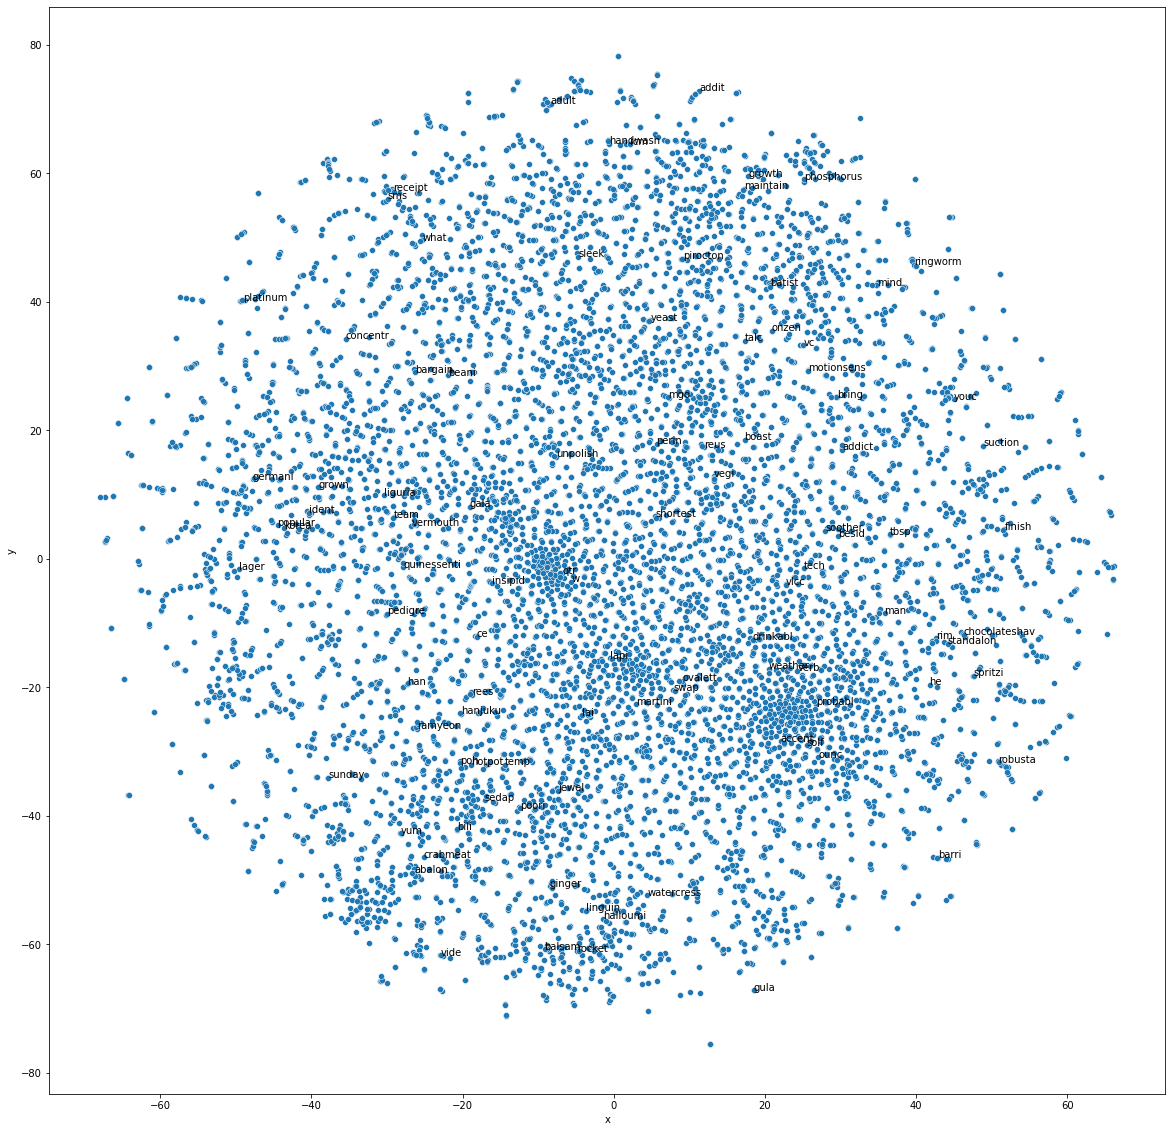

In [43]:
plot_w2v_model(w2v_descriptions)

## calculate the data embedding

To calculate the name and description embedding, I will just average the vectors and use np.zeros(0) for NaNs. This is not a very good idea, and doc2vec and so on are better alternatives, but for now I stick to KISS.

In [44]:
def embed_tokens(tokens, model):
  dims = w2v_names.wv["foo"].shape[0]
  vec = np.zeros(dims)
  if type(tokens) is list and len(tokens) > 0:
    vecs = [w2v_names.wv[token] for token in tokens if token in w2v_names.wv.vocab.keys()]
    if len(vecs) > 0:
      vec = vec + np.mean(vecs, axis=0)
  return vec

In [45]:
products_doc_df["name_vec"] = products_doc_df["name_tokens"].apply(lambda x: embed_tokens(x, w2v_names))
products_doc_df["description_vec"] = products_doc_df["description_tokens"].apply(lambda x: embed_tokens(x, w2v_names))

In [46]:
products_doc_df

,product_id,vendor_id,vendor_geohash,order_count,name_tokens,description_tokens,name_vec,description_vec
0,0,0,w21z6tu,116,"[chees, tofu]",NaN,"[-0.8070564866065979, 0.6667882204055786, -0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,1,w21z74d,30,"[naughti, nice, slice]","[chocol, slice]","[0.004672149661928415, -0.38932451605796814, -...","[0.7067714929580688, 0.01633399724960327, -0.9..."
2,2,2,w21xxgu,25,"[pork, dumpl, with, hot, chilli, vinaigrett]","[pcs, spici]","[0.14976847171783447, -0.42149946093559265, -0...","[-0.5587777495384216, -0.5966812372207642, -0...."
3,5,5,w21z6dm,39,"[chicken, dum, biryani, set]",NaN,"[-0.6621756553649902, -0.3983707129955292, 0.9...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,6,6,w21zts2,28,"[sesam, chicken, with, rice]",NaN,"[-0.3753787577152252, -0.44008851051330566, 1....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
487197,633143,701,w21zkpm,22,"[sriracha, chicken, whole, wheat, pita]",NaN,"[-0.217657208442688, 0.16565534472465515, 0.99...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
487198,633144,17,w23b5j9,22,"[dettol, liquid, hand, wash, sensit]","[dettol, liquid, hand, wash, kill, germ, ensur...","[1.8446578979492188, 0.2534513473510742, -0.73...","[0.576375424861908, 0.01538618840277195, -0.16..."
487199,633145,4135,w21ztw0,22,"[red, bean]",[pcs],"[0.29480215907096863, -0.5415980219841003, -1....","[-0.9718126058578491, -0.7518171668052673, -0...."
487200,633146,3121,w21z6vc,22,"[twister, meal]","[choic, twister, hash, brown, and, choic, drink]","[-1.0405967235565186, -0.7386456727981567, 0.4...","[-0.24818308651447296, 0.059859395027160645, 0..."


As discussed in "look at target" we are going to user a log10 clipped at 200 order_count

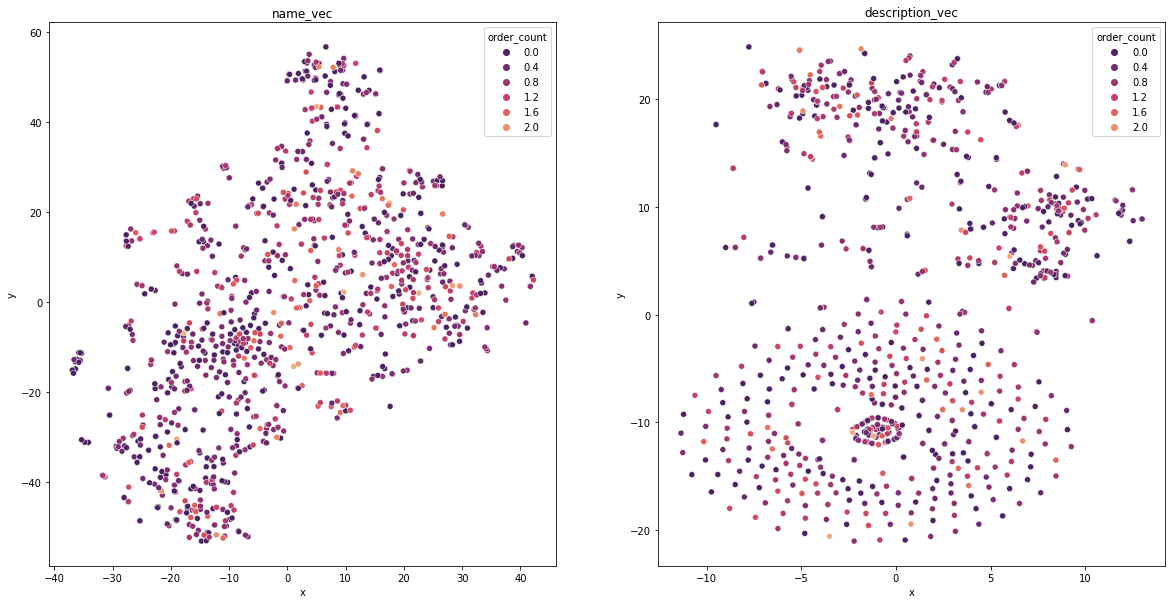

In [47]:
# look at the doc embeddings

products_doc_plot_df = products_doc_df.sample(1000)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
for i, col in enumerate(["name_vec", "description_vec"]):

  tsne = sklearn.manifold.TSNE(n_components=2)
  vectors = tsne.fit_transform(np.vstack(products_doc_plot_df[col].to_numpy()))

  vectors_df = pd.DataFrame(vectors, columns=["x", "y"])
  # take care: we dropped the index, so we can't just re-join old data
  vectors_df["order_count"] = products_doc_plot_df["order_count"].apply(lambda x: np.log10(np.clip(x, 0, 200))).tolist()

  sns.scatterplot(
      data=vectors_df,
      x="x",
      y="y",
      hue="order_count",
      palette="flare_r",
      ax=ax[i]
  )
  ax[i].set_title(col)
plt.show()

# Regression

## prepare data for learning

In [48]:
x = np.hstack([np.vstack(products_doc_df["name_vec"]), np.vstack(products_doc_df["description_vec"])])
y = np.log10(np.clip(products_doc_df["order_count"].to_numpy(), 0, 200))
x.shape, y.shape

((487202, 200), (487202,))

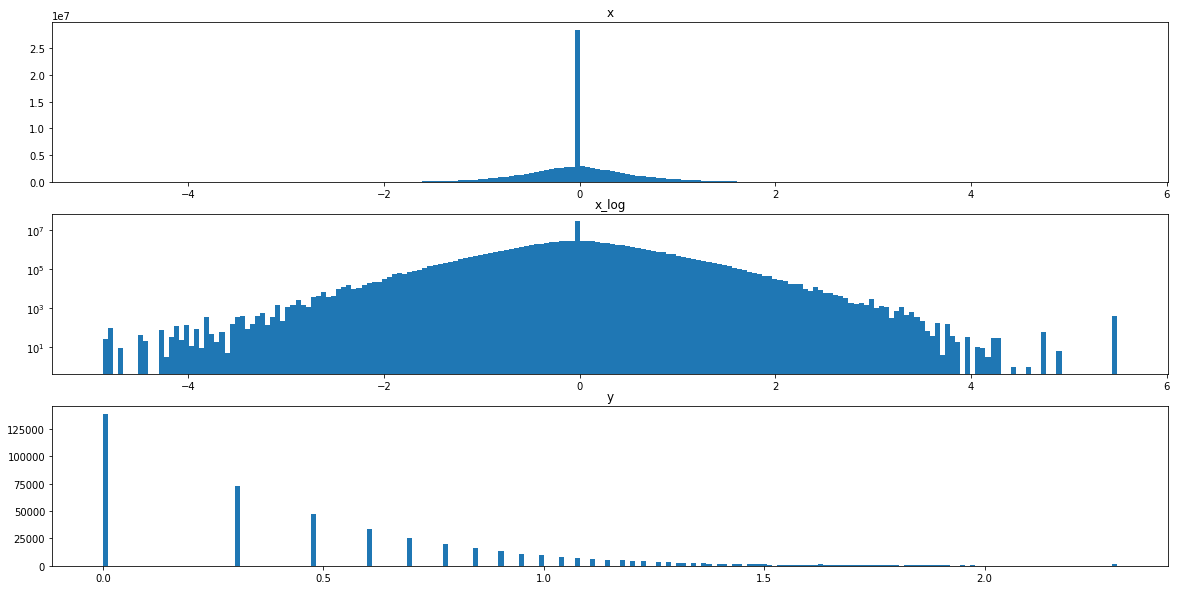

In [49]:
fig, ax = plt.subplots(3, 1, figsize=(20, 10))

ax[0].hist(x.flatten(), bins=200)
ax[0].set_title("x")

ax[1].hist(x.flatten(), bins=200)
ax[1].set_yscale("log")
ax[1].set_title("x_log")

ax[2].hist(y.flatten(), bins=200)
ax[2].set_title("y")

plt.show()

# baseline